In [1]:
# Установка Java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Загрузка Spark
!wget -q https://downloads.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz

# Распаковка Spark
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Установка PySpark
!pip install -q findspark

tar: spark-3.5.0-bin-hadoop3.tgz: Cannot open: No such file or directory
tar: Error is not recoverable: exiting now


In [2]:
from pyspark.sql.functions import mean, stddev, variance, corr, count

In [3]:
import findspark

findspark.init()

from pyspark.sql import SparkSession

# Создание Spark-сессии
spark = SparkSession.builder \
    .appName("Google Colab Spark Example") \
    .config("spark.driver.memory", "2g") \
    .getOrCreate()

# Проверка
print("Spark version:", spark.version)

Spark version: 3.5.3


In [4]:
# Загрузка данных
dim_branches = spark.read.csv("/content/dim_branches_recreated.csv", header=True, inferSchema=True)
dim_employees = spark.read.csv("/content/dim_employees_recreated.csv", header=True, inferSchema=True)
dim_periods = spark.read.csv("/content/dim_periods_recreated.csv", header=True, inferSchema=True)
fact_table = spark.read.csv("/content/fact_table_recreated.csv", header=True, inferSchema=True)

In [5]:
dim_branches.printSchema()
dim_branches.show(5)

root
 |-- Branch_ID: integer (nullable = true)
 |-- City: string (nullable = true)

+---------+-------------+
|Branch_ID|         City|
+---------+-------------+
|      103|     New York|
|      102|     New York|
|      101|San Francisco|
|      104|     New York|
|      103|      Chicago|
+---------+-------------+
only showing top 5 rows



In [6]:
dim_employees.printSchema()
dim_employees.show(5)

root
 |-- Employee_ID: integer (nullable = true)
 |-- Full_Name: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Hire_Date: date (nullable = true)
 |-- Department: string (nullable = true)
 |-- Branch_ID: integer (nullable = true)

+-----------+----------+----------+----------+----------+---------+
|Employee_ID| Full_Name|  Position| Hire_Date|Department|Branch_ID|
+-----------+----------+----------+----------+----------+---------+
|       8270|Employee_1|Consultant|2015-01-01|        IT|      103|
|       1860|Employee_2|   Manager|2015-01-08|Operations|      103|
|       6390|Employee_3|Consultant|2015-01-15|     Sales|      102|
|       6191|Employee_4|   Analyst|2015-01-22|        HR|      101|
|       6734|Employee_5|   Analyst|2015-01-29|Operations|      104|
+-----------+----------+----------+----------+----------+---------+
only showing top 5 rows



In [7]:
dim_periods.printSchema()
dim_periods.show(5)

root
 |-- Period: timestamp (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)

+-------------------+-----+----+-------+
|             Period|Month|Year|Quarter|
+-------------------+-----+----+-------+
|2024-01-01 00:00:00|    1|2024|      1|
|2024-02-01 00:00:00|    2|2024|      1|
|2024-03-01 00:00:00|    3|2024|      1|
|2024-04-01 00:00:00|    4|2024|      2|
|2024-05-01 00:00:00|    5|2024|      2|
+-------------------+-----+----+-------+
only showing top 5 rows



In [8]:
fact_table.printSchema()
fact_table.show(5)

root
 |-- Payroll_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Gross_Amount: double (nullable = true)
 |-- Tax_Amount: double (nullable = true)
 |-- Other_Deductions: double (nullable = true)
 |-- Net_Amount: double (nullable = true)
 |-- Payment_Date: date (nullable = true)
 |-- Branch_ID: integer (nullable = true)

+----------+-----------+-------------------+------------+----------+----------------+------------------+------------+---------+
|Payroll_ID|Employee_ID|             Period|Gross_Amount|Tax_Amount|Other_Deductions|        Net_Amount|Payment_Date|Branch_ID|
+----------+-----------+-------------------+------------+----------+----------------+------------------+------------+---------+
|         1|       8270|2024-01-01 00:00:00|     2888.73|   1484.61|          149.57|1254.5500000000002|  2024-01-31|      103|
|         2|       1860|2024-02-01 00:00:00|     3833.27|     903.3|          101.87|2828.1000

In [9]:
# 3. Объединение таблиц
data = fact_table \
    .join(dim_employees, fact_table["Employee_ID"] == dim_employees["Employee_ID"], "left") \
    .join(dim_branches, fact_table["Branch_ID"] == dim_branches["Branch_ID"], "left") \
    .join(dim_periods, fact_table["Period"] == dim_periods["Period"], "left")

In [10]:
# 4. Базовая информация о данных
data.printSchema()
data.show(2, 100, True)

root
 |-- Payroll_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Gross_Amount: double (nullable = true)
 |-- Tax_Amount: double (nullable = true)
 |-- Other_Deductions: double (nullable = true)
 |-- Net_Amount: double (nullable = true)
 |-- Payment_Date: date (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- Employee_ID: integer (nullable = true)
 |-- Full_Name: string (nullable = true)
 |-- Position: string (nullable = true)
 |-- Hire_Date: date (nullable = true)
 |-- Department: string (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- Branch_ID: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Period: timestamp (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Quarter: integer (nullable = true)

-RECORD 0-------------------------------
 Payroll_ID       | 1                   
 Employee_ID      | 8270                
 

In [11]:
# 5. Расчёт базовых статистик
stat_summary = data.select(
    mean("Gross_Amount").alias("avg_salary"),
    stddev("Gross_Amount").alias("stddev_salary"),
    variance("Gross_Amount").alias("variance_salary"),
    count("Gross_Amount").alias("count_salary")
)

stat_summary.show()

+-----------------+------------------+-----------------+------------+
|       avg_salary|     stddev_salary|  variance_salary|count_salary|
+-----------------+------------------+-----------------+------------+
|5138.403972973004|1484.3398558326287|2203264.807613229|        4440|
+-----------------+------------------+-----------------+------------+



In [12]:
from pyspark.sql.functions import min, max

# Additional calculations: minimum, maximum, percentiles
salary_stats = data.select(
    min("Gross_Amount").alias("min_salary"),
    max("Gross_Amount").alias("max_salary")
)

# Approximate percentiles for salary (25th, 50th (median), 75th)
percentiles = data.approxQuantile("Gross_Amount", [0.25, 0.5, 0.75], 0.01)

# Convert to Pandas for visualization
salary_distribution = data.select("Gross_Amount").toPandas()



In [13]:
# Import visualization libraries
import matplotlib.pyplot as plt
import pandas as pd

# Display statistics
salary_stats_df = pd.DataFrame({
    "Metric": ["Min Salary", "Max Salary", "25th Percentile", "Median (50th Percentile)", "75th Percentile"],
    "Value": [
        salary_stats.collect()[0]["min_salary"],
        salary_stats.collect()[0]["max_salary"],
        percentiles[0],
        percentiles[1],
        percentiles[2]
    ]
})
print(salary_stats_df)



                     Metric    Value
0                Min Salary   617.97
1                Max Salary  9789.66
2           25th Percentile  4097.95
3  Median (50th Percentile)  5085.52
4           75th Percentile  6078.43


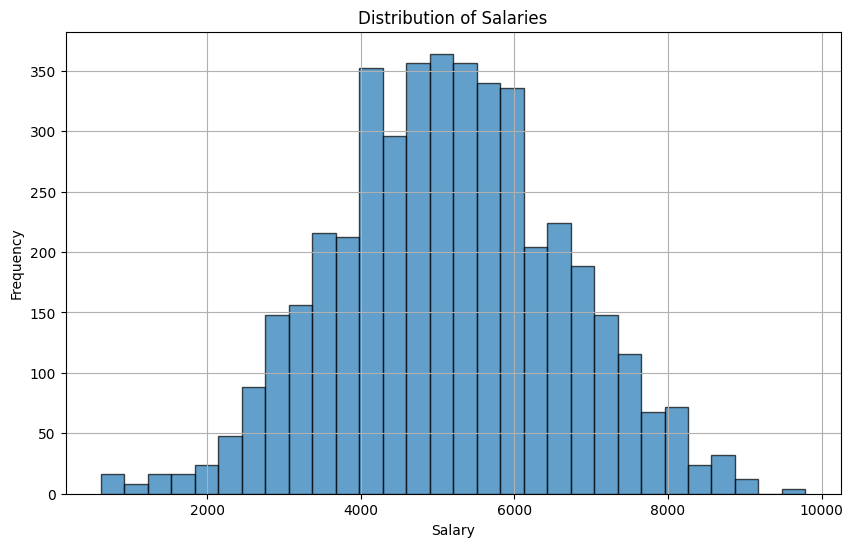

In [14]:
# Plot histogram of salary distribution
plt.figure(figsize=(10, 6))
plt.hist(salary_distribution["Gross_Amount"], bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Salaries")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()



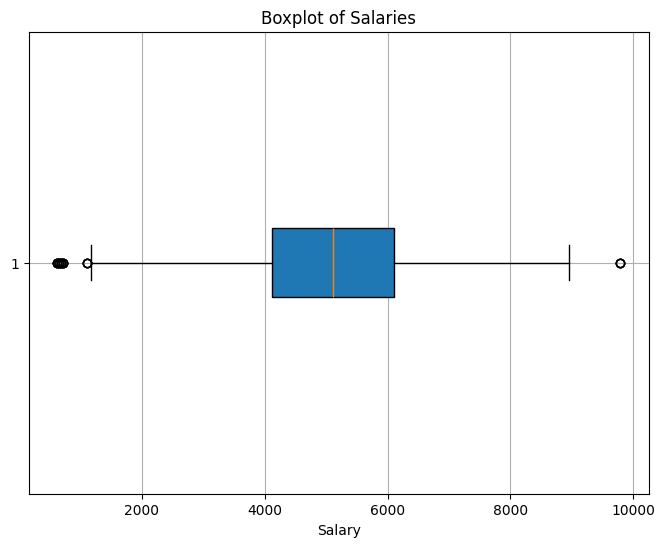

In [15]:
# Plot boxplot for salary distribution
plt.figure(figsize=(8, 6))
plt.boxplot(salary_distribution["Gross_Amount"], vert=False, patch_artist=True)
plt.title("Boxplot of Salaries")
plt.xlabel("Salary")
plt.grid(True)
plt.show()

	•	Основная масса зарплат находится в диапазоне от ~4000 до ~6000.
	•	Выбросы присутствуют как на низких, так и на высоких значениях, что требует дополнительного анализа:
	•	Низкие выбросы могут быть связаны с некорректными данными или специфическими условиями работы.
	•	Высокие выбросы часто связаны с руководящими позициями или уникальными должностями.

In [16]:

# 6. Корреляция между зарплатой и количеством завершённых проектов
correlation = data.select(corr("Gross_Amount", "Tax_Amount").alias("correlation_salary_taxes"))
correlation.show()

+------------------------+
|correlation_salary_taxes|
+------------------------+
|    -0.01864035517711...|
+------------------------+



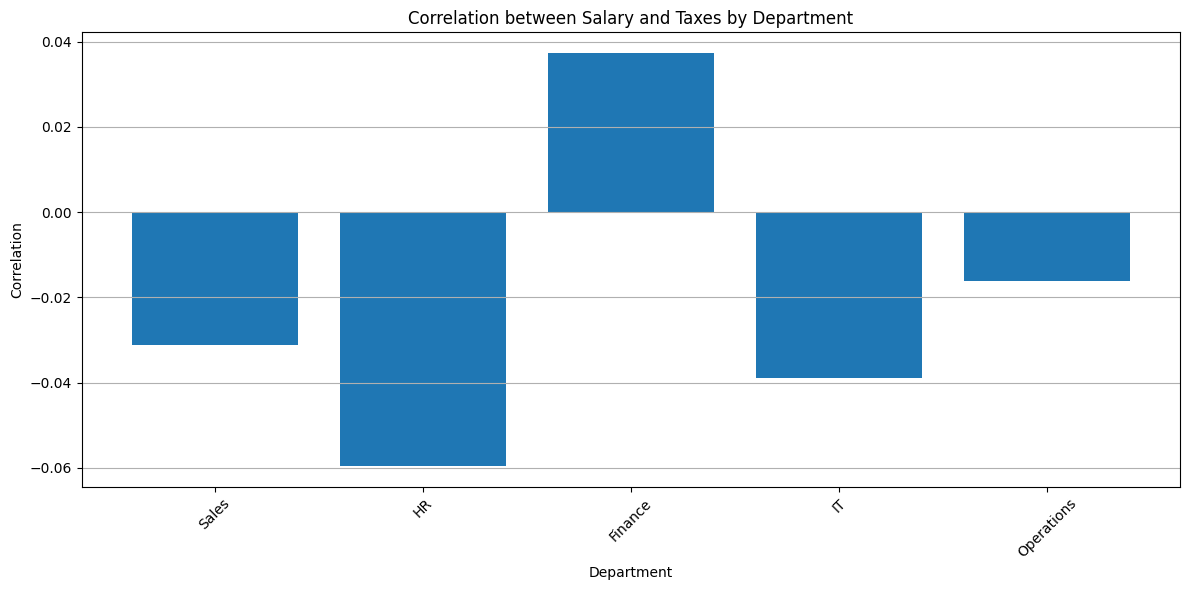

In [17]:
# Correlation between salary and taxes by department
department_correlation = data.groupBy("Department").agg(
    corr("Gross_Amount", "Tax_Amount").alias("correlation_salary_taxes")
)

# Convert to Pandas for easier visualization
department_correlation_df = department_correlation.toPandas()

# Plot correlation by department
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(department_correlation_df["Department"], department_correlation_df["correlation_salary_taxes"])
plt.title("Correlation between Salary and Taxes by Department")
plt.xlabel("Department")
plt.ylabel("Correlation")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

	1.	Отрицательная корреляция:
	•	Sales (-0.031), HR (-0.060), IT (-0.039), и Operations (-0.016) демонстрируют слабую отрицательную корреляцию между зарплатами и налогами. Это указывает на то, что, хотя налоги немного уменьшаются с ростом зарплаты, связь крайне слабая и, скорее всего, статистически незначима.
	2.	Положительная корреляция:
	•	В департаменте Finance (0.037) наблюдается слабая положительная корреляция, что указывает на чуть большую тенденцию к увеличению налогов с ростом зарплат. Однако, как и в других департаментах, связь слабая и может быть случайной.
	3.	Общие тенденции:
	•	Во всех департаментах корреляция находится близко к нулю. Это говорит о том, что между зарплатами и налогами в данной организации нет значительной линейной зависимости, и налоги, вероятно, рассчитываются по сложным правилам, не связанным напрямую с зарплатой.

In [18]:
# Вывести данные в консоли
print(department_correlation_df)

# Если нужно сохранить в файл:
department_correlation_df.to_csv("department_correlation.csv", index=False)

   Department  correlation_salary_taxes
0       Sales                 -0.031283
1          HR                 -0.059600
2     Finance                  0.037338
3          IT                 -0.038843
4  Operations                 -0.016210


In [19]:

# 7. Средняя зарплата по филиалам
from pyspark.sql.functions import mean

# Средняя зарплата по филиалам (например, по городам)
avg_salary_by_branch = data.groupBy("City").agg(
    mean("Gross_Amount").alias("avg_salary")
)

avg_salary_by_branch.show()

+-------------+-----------------+
|         City|       avg_salary|
+-------------+-----------------+
|San Francisco|5138.403972972975|
|      Chicago|5138.403972972975|
|        Miami|5138.403972972975|
|     New York|5138.403972972975|
+-------------+-----------------+



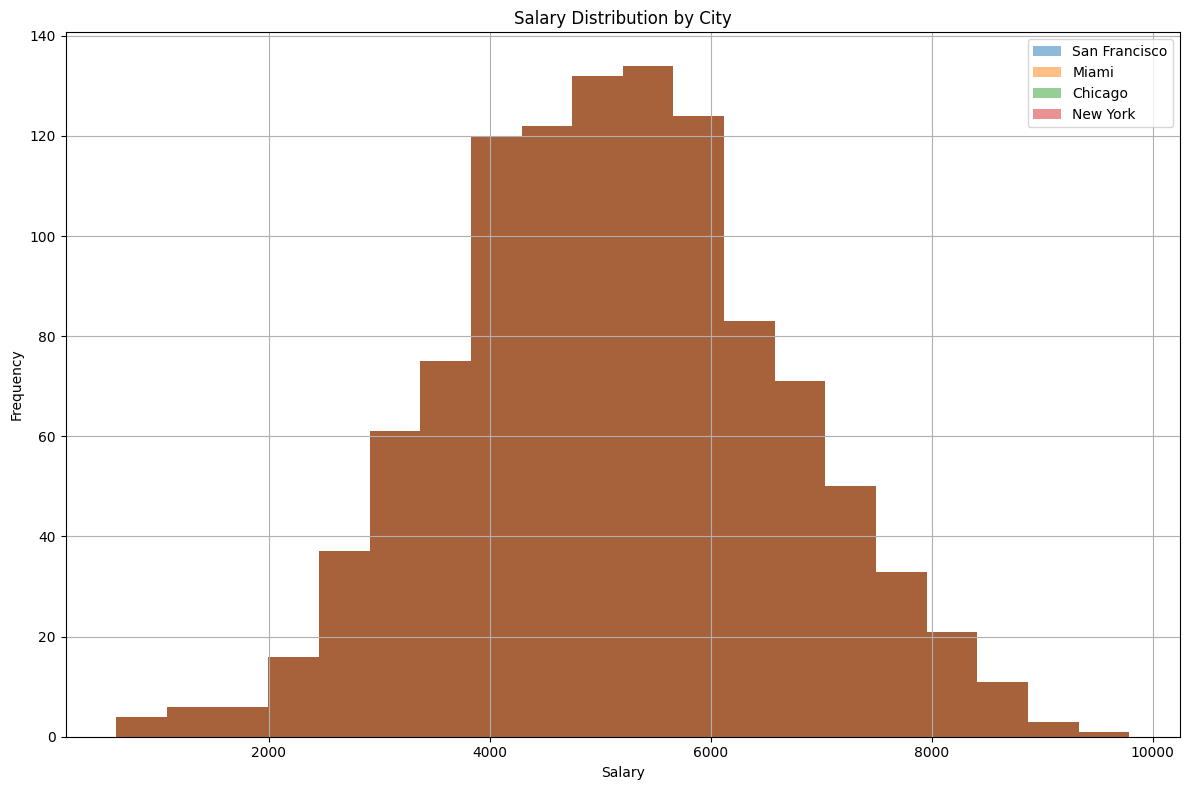

In [20]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
salary_by_city = data.select("City", "Gross_Amount").toPandas()

# Plot histogram for each city
cities = salary_by_city["City"].unique()
plt.figure(figsize=(12, 8))

for city in cities:
    city_data = salary_by_city[salary_by_city["City"] == city]["Gross_Amount"]
    plt.hist(city_data, bins=20, alpha=0.5, label=city)

plt.title("Salary Distribution by City")
plt.xlabel("Salary")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



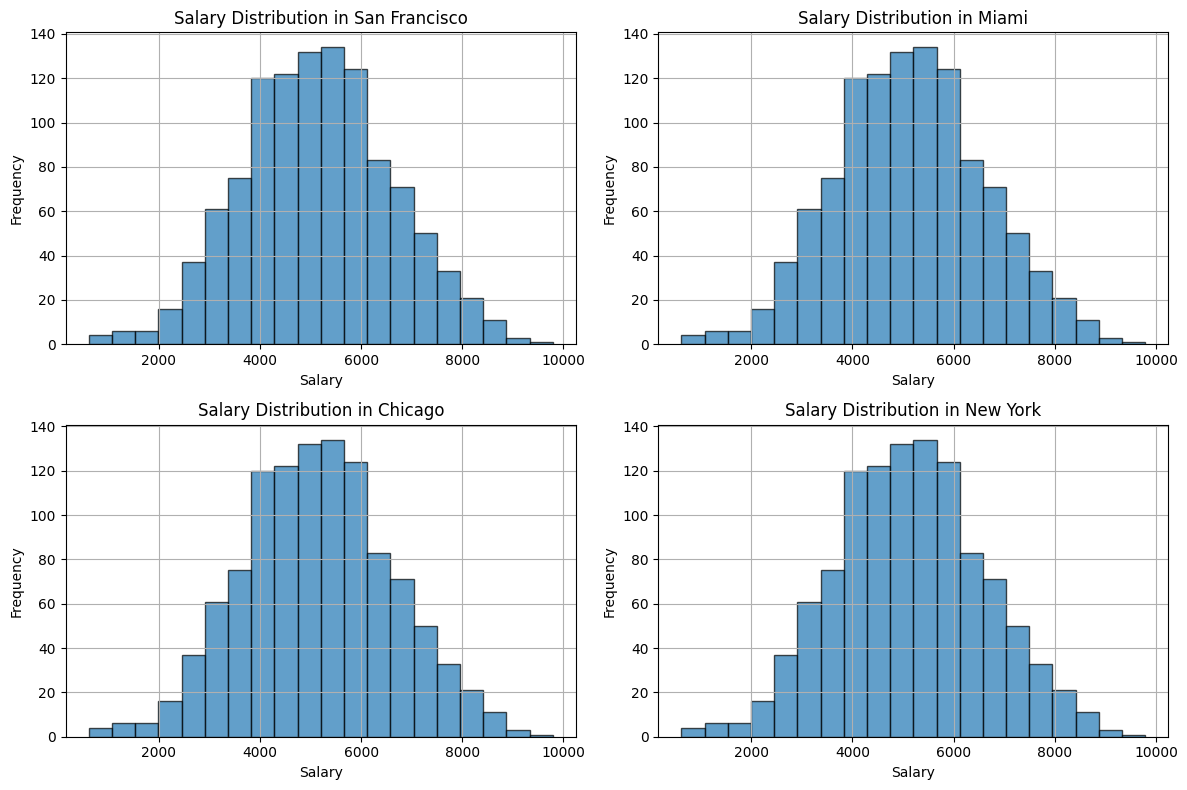

In [21]:
# Plot separate histograms for each city
cities = salary_by_city["City"].unique()
plt.figure(figsize=(12, 8))

for i, city in enumerate(cities, 1):
    city_data = salary_by_city[salary_by_city["City"] == city]["Gross_Amount"]
    plt.subplot(2, 2, i)  # Разделить на 4 графика (2x2)
    plt.hist(city_data, bins=20, alpha=0.7, edgecolor="k")
    plt.title(f"Salary Distribution in {city}")
    plt.xlabel("Salary")
    plt.ylabel("Frequency")
    plt.grid(True)

plt.tight_layout()
plt.show()

1.	Общая форма распределения:
	•	Распределения зарплат во всех городах (San Francisco, Miami, Chicago, New York) имеют схожую колоколообразную форму, что указывает на нормальное распределение.
	•	Это говорит о том, что в каждом городе большинство сотрудников получают зарплаты, близкие к средней (около 5138.40).
	2.	Диапазон зарплат:
	•	Во всех городах зарплаты варьируются от ~2000 до ~10000.
	•	Пик распределения в каждом городе приходится на диапазон 4000–6000, что соответствует основному интервалу (от 25-го до 75-го перцентиля) в общих данных.
	3.	Сравнение городов:
	•	Поскольку графики почти идентичны, можно предположить, что структура зарплат и позиций сотрудников во всех филиалах одинаковая.
	•	Нет значительных различий в уровне зарплат между городами.

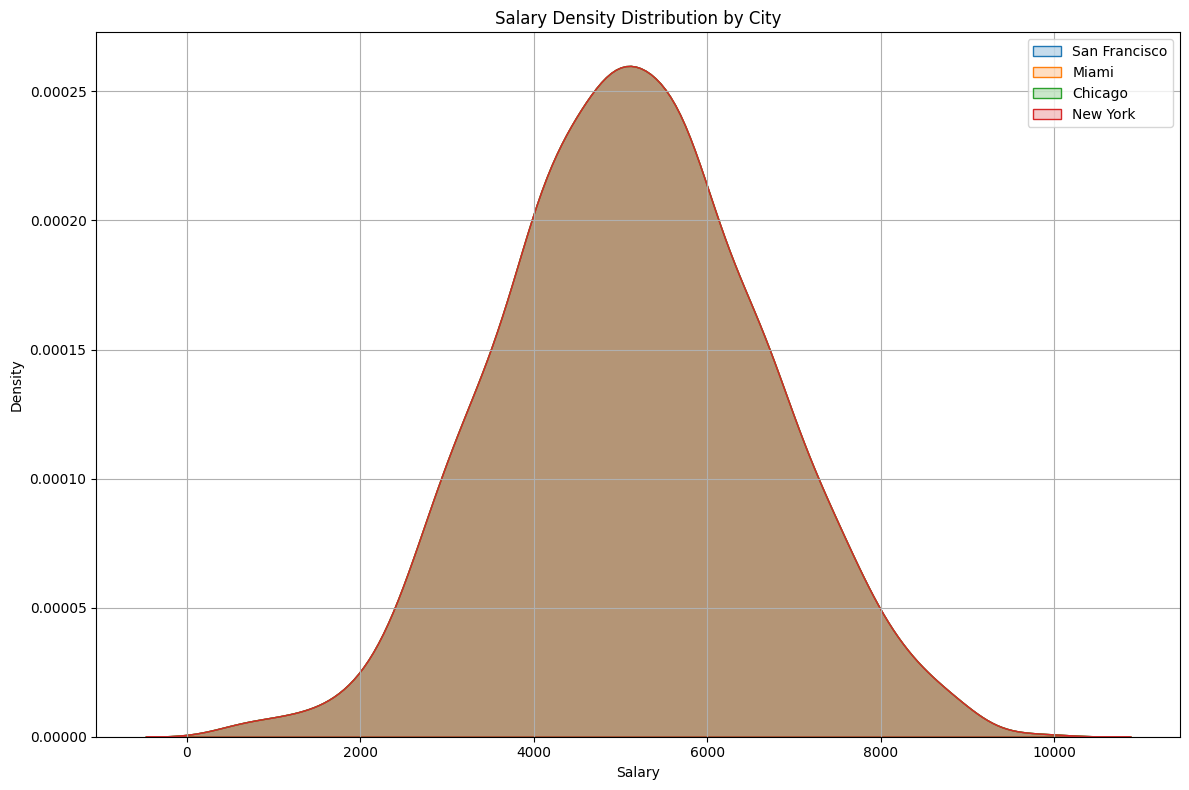

In [22]:
import seaborn as sns

plt.figure(figsize=(12, 8))
for city in cities:
    city_data = salary_by_city[salary_by_city["City"] == city]["Gross_Amount"]
    sns.kdeplot(city_data, label=city, fill=True)

plt.title("Salary Density Distribution by City")
plt.xlabel("Salary")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

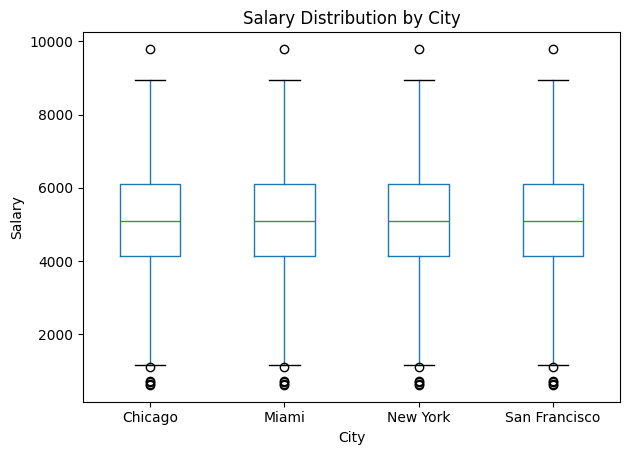

In [23]:
# Boxplot for salary distribution by city
plt.figure(figsize=(10, 6))
salary_by_city.boxplot(column="Gross_Amount", by="City", grid=False)
plt.title("Salary Distribution by City")
plt.xlabel("City")
plt.ylabel("Salary")
plt.suptitle("")  # Remove the automatic title
plt.tight_layout()
plt.show()

In [24]:
from pyspark.sql.functions import to_date, col, year, month

# 8. Работа с временными данными

data = data.withColumn("date_column", to_date(col("Payment_Date"), "yyyy-MM-dd"))
data = data.withColumn("year", year(col("date_column"))).withColumn("month", month(col("date_column")))

# Отображение данных с временными колонками
data.select("date_column", "year", "month").show(5)

+-----------+----+-----+
|date_column|year|month|
+-----------+----+-----+
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-01-31|2024|    1|
| 2024-02-29|2024|    2|
+-----------+----+-----+
only showing top 5 rows



In [25]:
monthly_avg_salary = data.groupBy("year", "month").agg(mean("Gross_Amount").alias("avg_salary"))
monthly_avg_salary.show()

+----+-----+-----------------+
|year|month|       avg_salary|
+----+-----+-----------------+
|2031|   12|          7718.67|
|2036|   11|          4369.72|
|2045|    6|7821.739999999999|
|2070|    2|           4779.5|
|2106|    2|          6709.82|
|2059|    4|           2002.7|
|2047|    4|          7165.65|
|2079|    2|          4494.37|
|2089|    8|          3163.55|
|2041|    1|          4975.37|
|2082|   12|          4268.13|
|2101|    8|          3570.01|
|2028|   10|          3532.44|
|2031|    2|          6050.46|
|2035|    7|          7170.47|
|2056|   10|          6741.24|
|2089|    1|          5848.26|
|2093|    4|          4320.16|
|2042|    2|          5760.91|
|2044|    2|          5418.53|
+----+-----+-----------------+
only showing top 20 rows



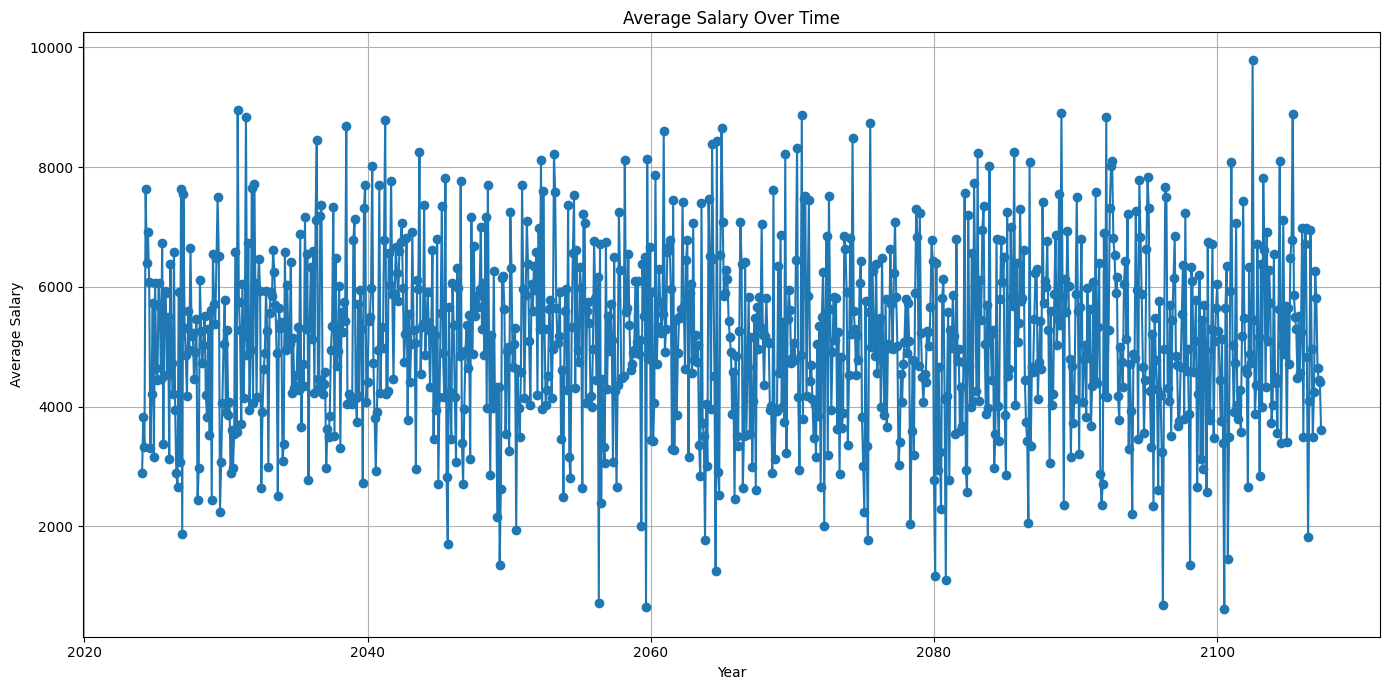

In [26]:

# Рассчёт средней зарплаты по годам и месяцам
monthly_avg_salary_df = data.groupBy("year", "month").agg(mean("Gross_Amount").alias("avg_salary")).toPandas()

# Сортировка данных для удобства визуализации
monthly_avg_salary_df = monthly_avg_salary_df.sort_values(by=["year", "month"])

# Построение графика
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(
    monthly_avg_salary_df["year"] + monthly_avg_salary_df["month"] / 12,
    monthly_avg_salary_df["avg_salary"],
    marker="o",
    linestyle="-",
    label="Avg Salary"
)
plt.title("Average Salary Over Time")
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.grid(True)
plt.tight_layout()
plt.show()


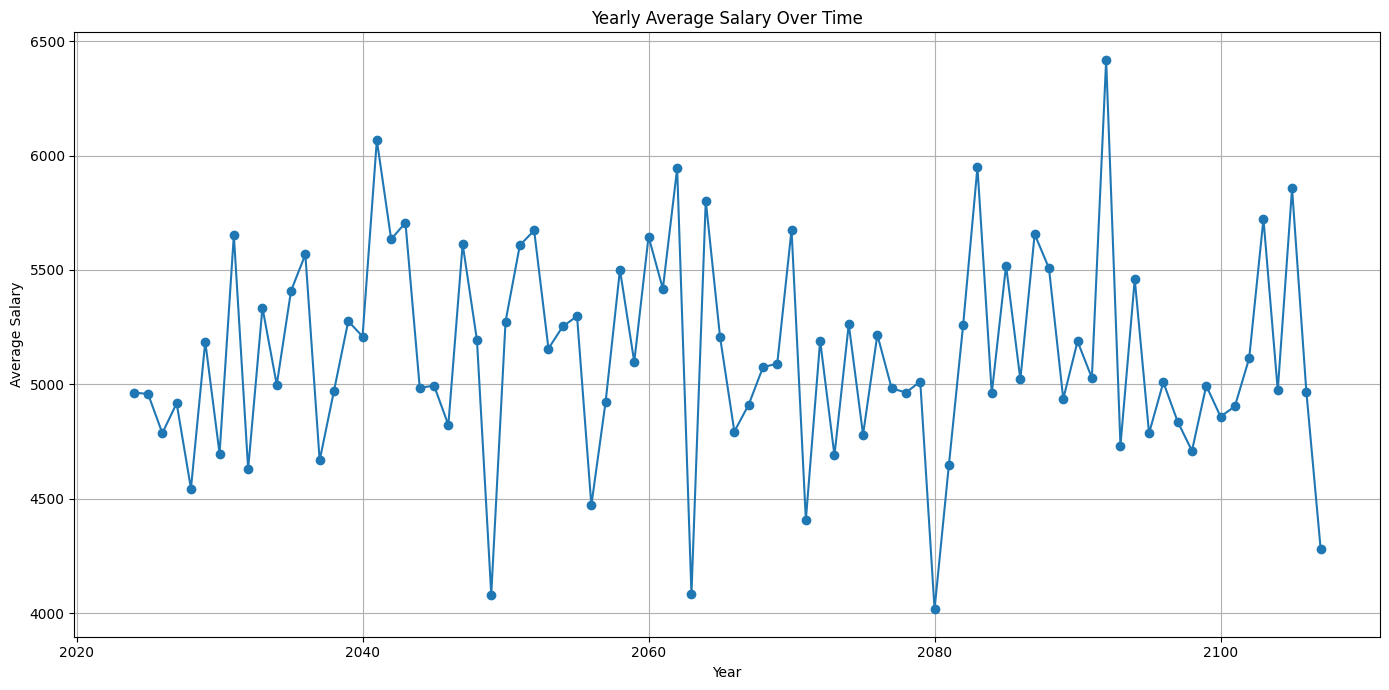

In [27]:
# Рассчёт средней зарплаты по годам
yearly_avg_salary_df = data.groupBy("year").agg(mean("Gross_Amount").alias("avg_salary")).toPandas()

# Сортировка данных по годам
yearly_avg_salary_df = yearly_avg_salary_df.sort_values(by="year")

# Построение графика средней зарплаты по годам
plt.figure(figsize=(14, 7))
plt.plot(
    yearly_avg_salary_df["year"],
    yearly_avg_salary_df["avg_salary"],
    marker="o",
    linestyle="-",
    label="Yearly Avg Salary"
)
plt.title("Yearly Average Salary Over Time")
plt.xlabel("Year")
plt.ylabel("Average Salary")
plt.grid(True)
plt.tight_layout()
plt.show()